In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12,4)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib

In [3]:
import numpy as np
import pandas as pd

In [4]:
DATA_DIR = pathlib.Path("data")

# Loading data

In [7]:
df = pd.read_csv("data/AEP_hourly.csv", parse_dates=["Datetime"], index_col="Datetime")

## Fix timestamps

In [9]:
df.index.is_monotonic, df.index.is_unique

(False, False)

In [10]:
df = df.sort_index()
df

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


### New index

In [11]:
new_idx = pd.date_range("2004-10-01 01:00:00", "2018-08-03 00:00:00", freq="1H")

In [13]:
dfi = df[~df.index.duplicated(keep='first')].reindex(new_idx)

In [14]:
dfi.index.is_monotonic, dfi.index.is_unique, dfi.index.freq

(True, True, <Hour>)

## Missing values

In [16]:
dfi.ffill(inplace=True)

# DalaModule

In [17]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

In [25]:
class ElectricityDataset(Dataset):
    """Dataset which samples the data from hourly electricity data."""

    def __init__(self, df, samples, hist_len=168, fct_len=24, col="AEP_MW"):
        self.hist_num = hist_len
        self.fct_num = fct_len
        self.hist_len = pd.Timedelta(hours=hist_len)
        self.fct_len = pd.Timedelta(hours=fct_len)
        self.offset = pd.Timedelta(hours=1)

        self.max_ts = df.index.max() - self.hist_len - self.fct_len + self.offset
        self.raw_data = df

        assert samples <= self.raw_data[:self.max_ts].shape[0]
        self.samples = samples
        self.col = col
        self.sample()

    def sample(self):
        """Sample individual series as needed."""
        
        self.sample_idx = (self
                           .raw_data[:self.max_ts]
                           .index
                           .to_series()
                           .sample(self.samples, replace=False)
                           .index)

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        start_ts = self.sample_idx[idx]

        hs, he = start_ts, start_ts + self.hist_len - self.offset
        fs, fe = he + self.offset, he + self.fct_len

        hist_data = self.raw_data[hs:].iloc[:self.hist_num]
        fct_data = self.raw_data[fs:].iloc[:self.fct_num]

        return (torch.Tensor(hist_data[self.col].values),
                torch.Tensor(fct_data[self.col].values))


class ElectricityDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self, df,
                 train_range=("2004", "2015"),
                 val_range=("2016","2017"),
                 test_range=("2018", None),
                 factor=0.5,
                 batch_size=64,
                 workers=3):

        super().__init__()
        self.raw_data = df
        self.train_range = train_range
        self.val_range = val_range
        self.test_range = test_range
        self.factor = factor
        self.batch_size = batch_size
        self.workers = workers

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = self.raw_data[slice(*self.train_range)]
            val_df = self.raw_data[slice(*self.val_range)]

            self.train_ds = ElectricityDataset(train_df,
                                               samples=int(self.factor * train_df.shape[0]))
            self.val_ds = ElectricityDataset(val_df,
                                             samples=int(self.factor * val_df.shape[0]))

        if stage == "test" or stage is None:
            test_df = self.raw_data[slice(*self.test_range)]
            self.test_ds = ElectricityDataset(test_df,
                                              samples=int(self.factor * test_df.shape[0]))

    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers)

In [26]:
ds = ElectricityDataset(dfi, 10)

hist_sample = torch.cat([ds[3][0].unsqueeze(0),
                         ds[5][0].unsqueeze(0)])

fct_sample = torch.cat([ds[3][1].unsqueeze(0),
                        ds[5][1].unsqueeze(0)])

# Encoder-decoder model with AR block

In [82]:
class ElectricityARModel(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model with explicit AR block."""
   
    def __init__(self,
                 hist_len=168,
                 fct_len=24,
                 ar_len=12,
                 num_layers=1,
                 hidden_units=8,
                 lr=1e-3):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.ar_len = ar_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.lr = lr

        self.lstm = nn.LSTM(input_size=1,
                            hidden_size=self.hidden_units,
                            num_layers=self.num_layers,
                            batch_first=True)
        self.linear = nn.Linear(self.hidden_units, 1)
        self.ar = nn.Linear(self.ar_len, 1)

    def forward(self, x):
        forecasts = x.clone()  # forecasts: (N, hist_len), ! additional memory
        _, (hh, cc) = self.lstm(x.view(x.shape[0], x.shape[1], 1))
        ed_val = x[:, [-1]].unsqueeze(1)  # ed_val: (N, 1, 1)

        for i in range(self.fct_len):
            ed_val, (hc, cc) = self.lstm(ed_val, (hh, cc))  # ed_val: (N, 1, hidden_units)
            ed_val = self.linear(ed_val)  # ed_val: (N, 1, 1)

            ar_val = self.ar(forecasts[:, -self.ar_len:])  # ar_val: (N, 1)
            forecasts = torch.cat([forecasts, ar_val + ed_val.squeeze(1)], dim=1)

        return forecasts[:, -self.fct_len:]

    def step(self, batch, batch_idx, stage="train"):
        x, y = batch
        fct = self(x)
        loss = F.mse_loss(fct, y)
        self.log(f"{stage}_mse", loss, prog_bar=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, stage="val")

    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, stage="test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [83]:
model = ElectricityARModel()
model(hist_sample)

tensor([[-11345.9385,  -5809.0688,   -660.6833,  -1697.4775,  -8705.8613,
           -775.9301,  -3585.3999,    -18.8013,  -8482.1631, -11973.0244,
          -5402.3018,   5668.1196,    160.1737,  -1555.4924,   1678.5016,
           4360.8379,    -95.4400,  -3309.6814,  -2073.9309,   5151.7871,
           5915.9092,    -87.7415,  -2356.6570,   1814.4729],
        [-10178.9805,  -6021.8447,  -1682.4119,  -1832.9111,  -6914.8589,
           -217.9081,  -2193.1650,    916.7177,  -5886.0977,  -9120.7666,
          -4237.3169,   4771.3672,    626.2549,   -813.4650,   1556.3708,
           3628.3813,     13.4363,  -2785.9097,  -2069.4844,   3755.9343,
           4687.5342,     31.1133,  -1942.4539,   1281.8329]])

# Training

In [78]:
LIMH, LIML =26e3, 9e3

In [95]:
dfs = (2 * dfi - LIML - LIMH) / (LIMH - LIML)

ds = ElectricityDataModule(dfs, batch_size=32)
model = ElectricityARModel(lr=1e-3, hidden_units=64)
trainer = pl.Trainer(max_epochs=5, progress_bar_refresh_rate=1)
trainer.fit(model, ds)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 17.2 K
1 | linear | Linear | 65    
2 | ar     | Linear | 13    
----------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [96]:
hist_sample_scaled = (2 * hist_sample - LIML - LIMH) / (LIMH - LIML)

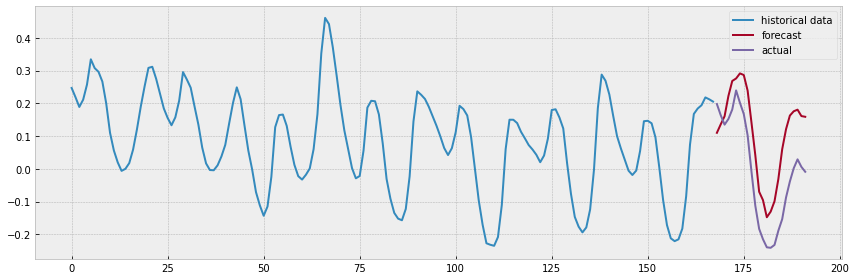

In [97]:
plt.plot((( 2 * hist_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[0], label="historical data")
plt.plot(np.arange(168, 192, 1), model(hist_sample_scaled).detach().numpy()[0], label="forecast")
plt.plot(np.arange(168, 192, 1), (( 2 * fct_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[0], label="actual")

plt.legend(loc=0)
plt.tight_layout()

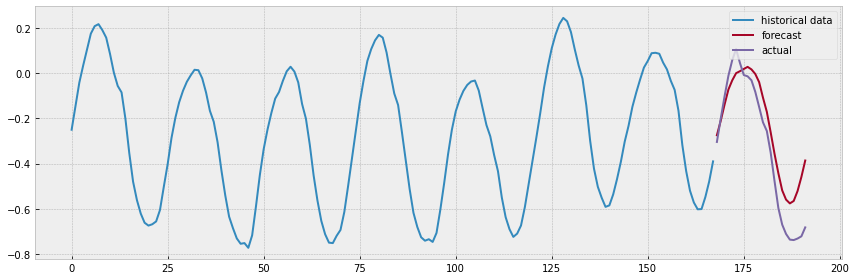

In [98]:
plt.plot((( 2 * hist_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[1], label="historical data")
plt.plot(np.arange(168, 192, 1), model(hist_sample_scaled).detach().numpy()[1], label="forecast")
plt.plot(np.arange(168, 192, 1), (( 2 * fct_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[1], label="actual")

plt.legend(loc=0)
plt.tight_layout()

In [99]:
dl = ds.val_dataloader()

In [100]:
for x in dl:
    fct = model(x[0])
    break

In [101]:
x

[tensor([[-0.3008, -0.2798, -0.2752,  ..., -0.4607, -0.2706, -0.2098],
         [-0.3789, -0.3953, -0.4181,  ..., -0.0806, -0.0980, -0.1447],
         [-0.1632, -0.1354, -0.1428,  ..., -0.4936, -0.4658, -0.4294],
         ...,
         [-0.6602, -0.6679, -0.6666,  ..., -0.3299, -0.3756, -0.4109],
         [-0.1813, -0.3149, -0.3920,  ..., -0.1922, -0.2561, -0.3821],
         [-0.6186, -0.7282, -0.8039,  ..., -0.5154, -0.4826, -0.5005]]),
 tensor([[-0.2495, -0.2975, -0.3428, -0.3635, -0.3907, -0.4025, -0.4209, -0.4649,
          -0.4586, -0.4841, -0.4958, -0.4880, -0.3968, -0.4119, -0.4968, -0.6194,
          -0.6734, -0.7011, -0.7073, -0.6991, -0.6640, -0.5459, -0.3755, -0.3145],
         [-0.1626, -0.2111, -0.2719, -0.3001, -0.3958, -0.5252, -0.6275, -0.6833,
          -0.7349, -0.7496, -0.7418, -0.6912, -0.6106, -0.5196, -0.4476, -0.3972,
          -0.3460, -0.3067, -0.2732, -0.2469, -0.2307, -0.2293, -0.2312, -0.2508],
         [-0.3654, -0.3286, -0.3058, -0.3205, -0.3405, -0.3768, 

In [102]:
fct = fct.detach().numpy()

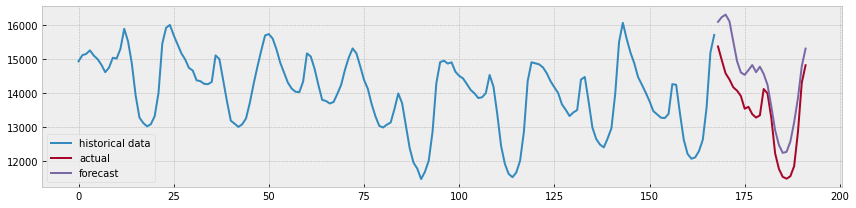

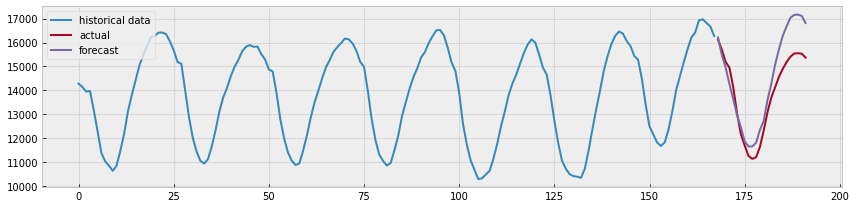

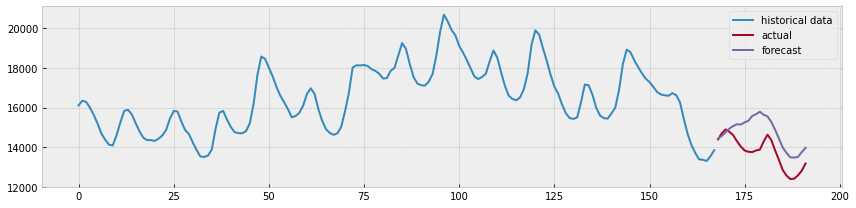

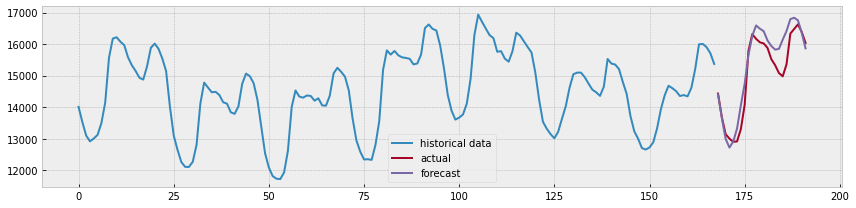

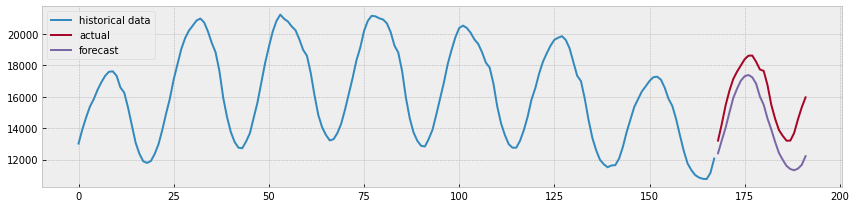

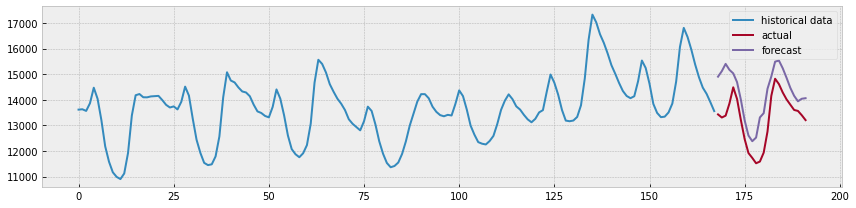

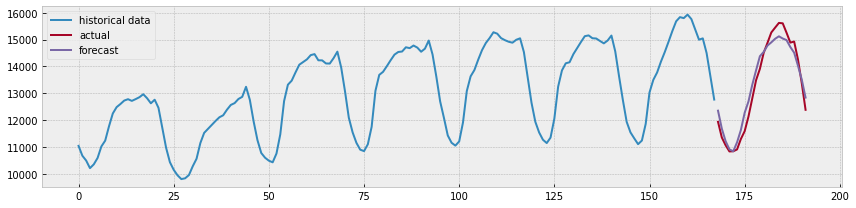

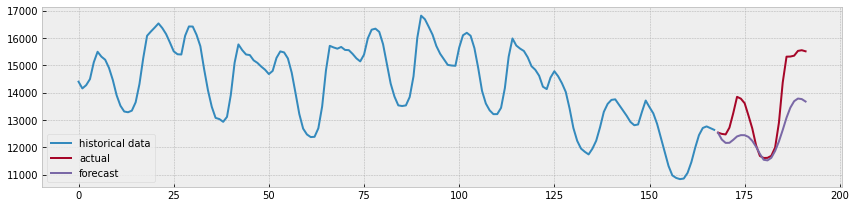

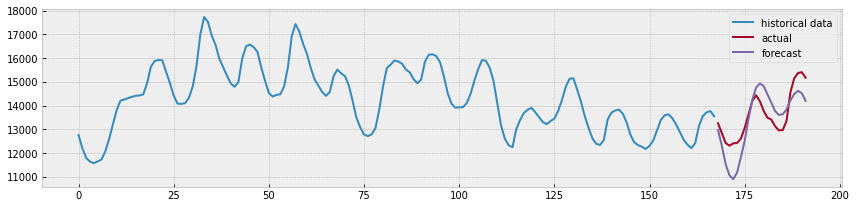

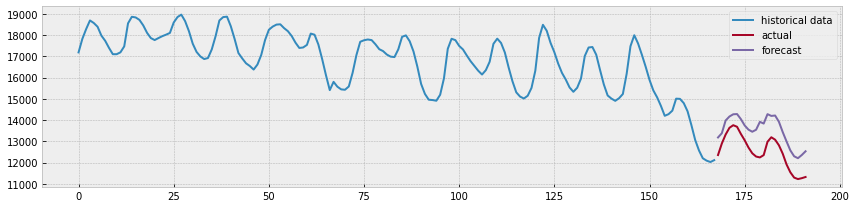

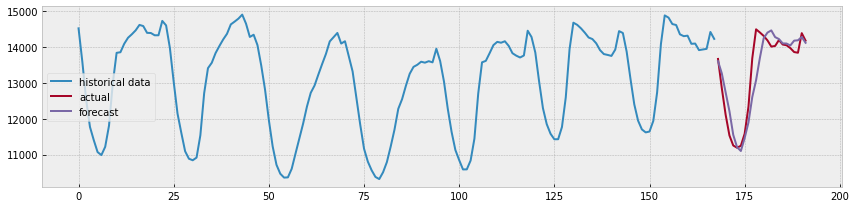

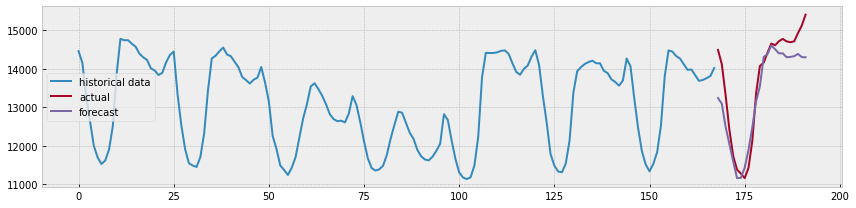

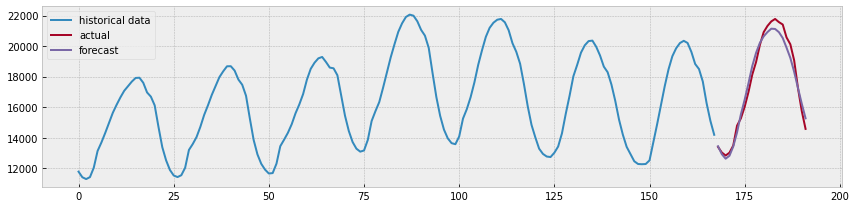

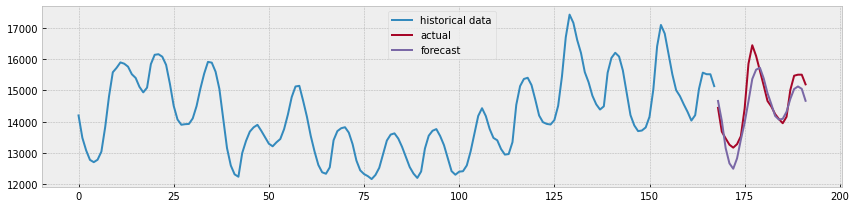

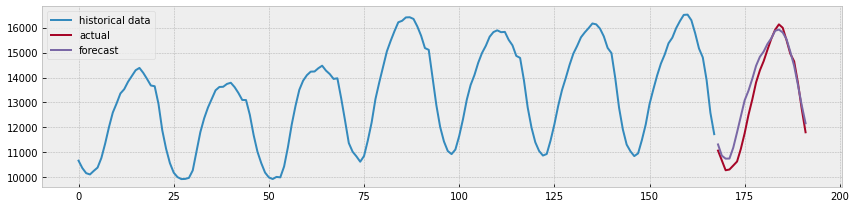

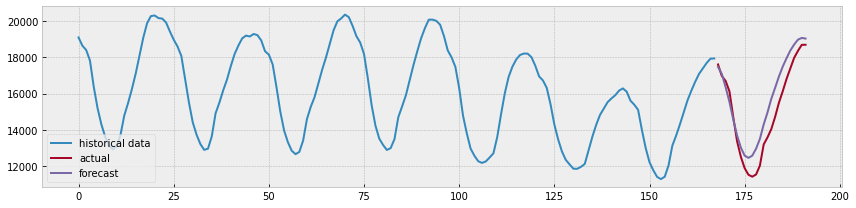

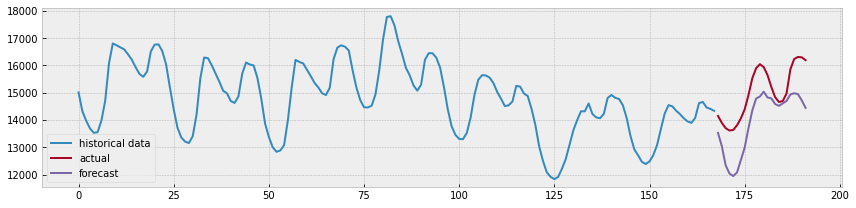

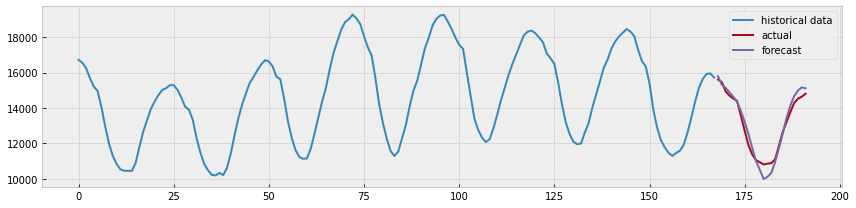

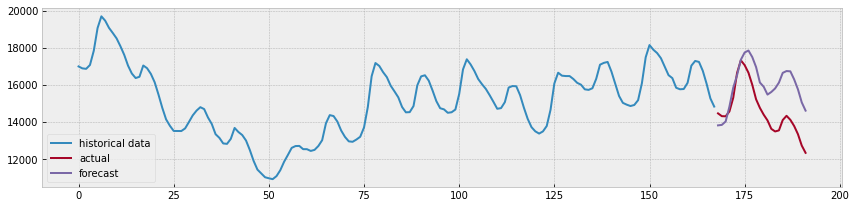

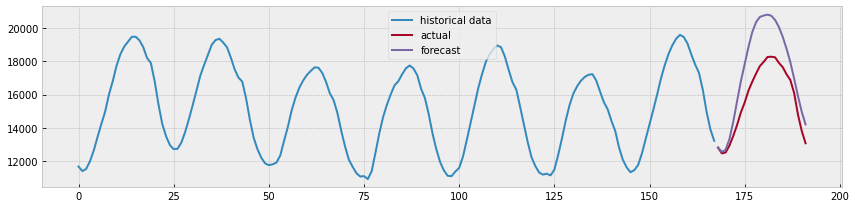

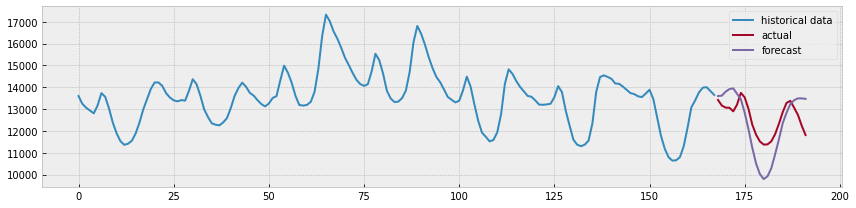

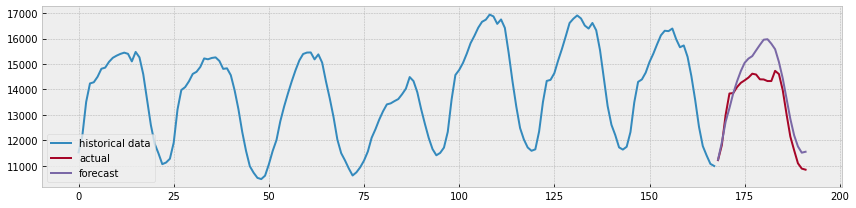

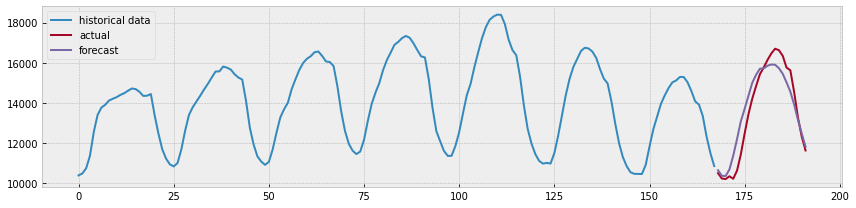

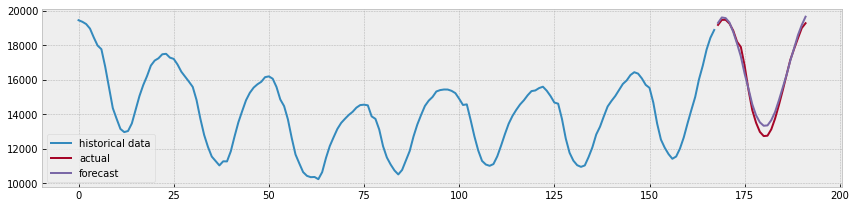

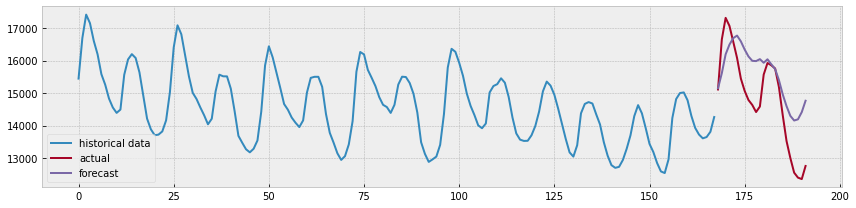

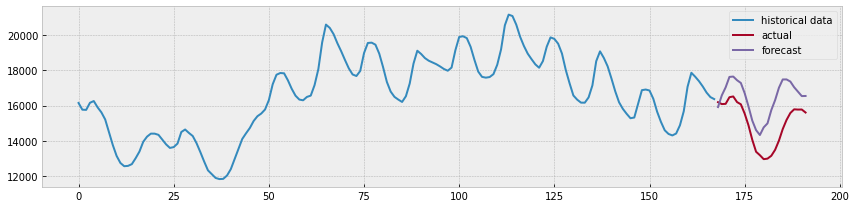

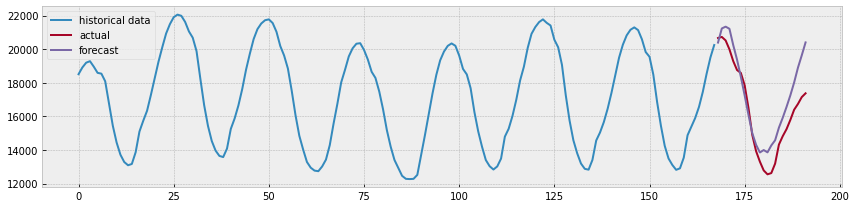

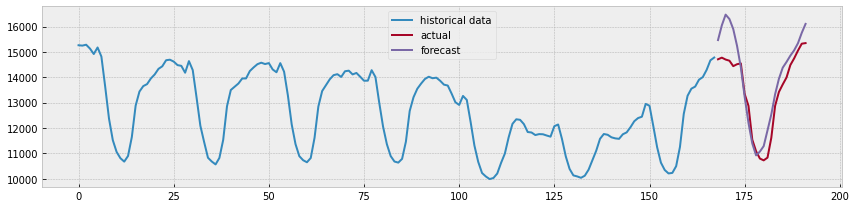

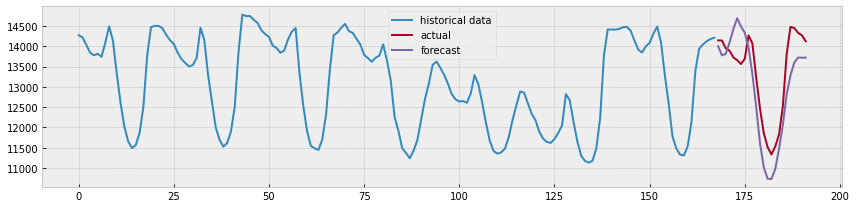

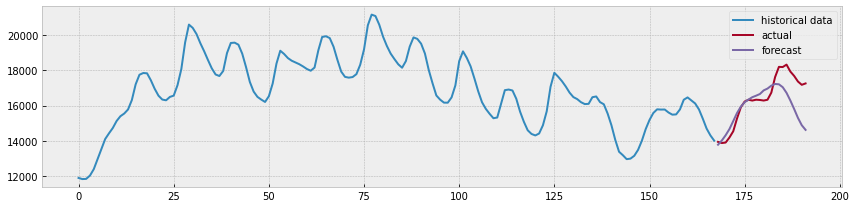

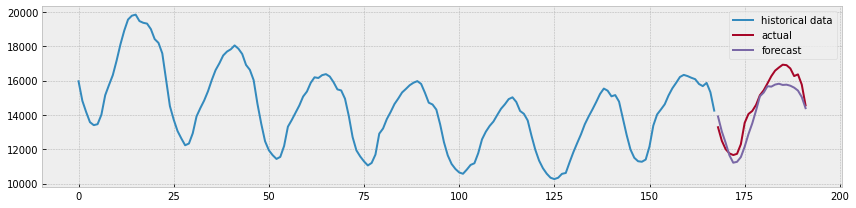

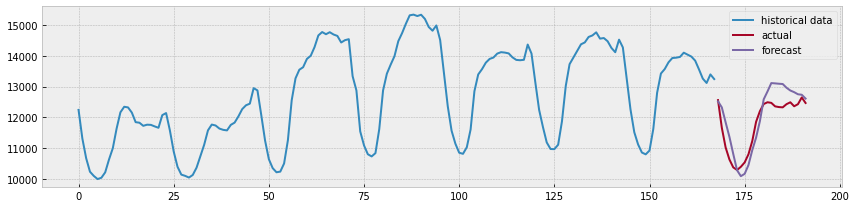

In [103]:
for stream in range(32):
    plt.figure(figsize=(12,3))
    plt.plot((x[0][stream] * (LIMH - LIML) + (LIMH + LIML)) / 2, label="historical data")
    plt.plot(np.arange(168, 192, 1), (x[1][stream] * (LIMH - LIML) + (LIMH + LIML)) / 2, label="actual")
    plt.plot(np.arange(168, 192, 1), (fct[stream] * (LIMH - LIML) + (LIMH + LIML)) / 2, label="forecast")
    plt.legend(loc=0)
    plt.tight_layout()
    plt.show()